# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4


In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [5]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip --no-check-certificate
!unzip dogImages.zip
!aws s3 cp dogImages s3://projectdatahieu/ --recursive

--2024-08-27 17:09:06--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.32, 52.219.120.200, 52.219.113.64, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.32|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  42.5MB/s    in 35s     

2024-08-27 17:09:41 (30.7 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogIma

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [9]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning-rate": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 32, 64, 128])
}

metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [14]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="HP",
    role=sagemaker.get_execution_role(),
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.m5.large",
    py_version="py3",
) # TODO: Your estimator here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="Test Loss",
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metric_definitions,
    max_jobs=1,
    max_parallel_jobs=2,
    objective_type="Minimize",
) # TODO: Your HP tuner here

In [11]:
os.environ['SM_CHANNEL_TRAINING'] = 's3://projectdatahieu/'
os.environ['SM_MODEL_DIR'] = 's3://projectdatahieu/model/'
os.environ['SM_OUTPUT_DATA_DIR'] = 's3://projectdatahieu/output/'

In [15]:
# TODO: Fit your HP Tuner
tuner.fit({"training": 's3://projectdatahieu/'}) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................................!


In [16]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "learning-rate": best_estimator.hyperparameters()['learning-rate'],
                  }
hyperparameters


2024-08-28 16:59:35 Starting - Preparing the instances for training
2024-08-28 16:59:35 Downloading - Downloading the training image
2024-08-28 16:59:35 Training - Training image download completed. Training in progress.
2024-08-28 16:59:35 Uploading - Uploading generated training model
2024-08-28 16:59:35 Completed - Resource retained for reuse


{'batch-size': 128, 'learning-rate': '0.005775191774724053'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [133]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100",
        "eval.save_interval": "10"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [18]:
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="MAIN",
    role=sagemaker.get_execution_role(),
    instance_count=2,
    instance_type="ml.m5.large",
    framework_version="1.8.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)
estimator.fit({"training": 's3://projectdatahieu/'}) # TODO: Your estimator here

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: MAIN-2024-08-28-17-01-23-239


2024-08-28 17:01:24 Starting - Starting the training job...
2024-08-28 17:01:53 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-08-28 17:02:22 Downloading - Downloading input data......
2024-08-28 17:03:22 Downloading - Downloading the training image...
2024-08-28 17:03:54 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-28 17:03:57,166 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-08-28 17:03:57,169 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-08-28 17:03:57,180 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-08-28 17:03:57,183 sagemaker_pytorch_container.training INF

In [19]:
# TODO: Plot a debugging output.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
description

{'TrainingJobName': 'MAIN-2024-08-28-17-01-23-239',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:834258455530:training-job/MAIN-2024-08-28-17-01-23-239',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-834258455530/MAIN-2024-08-28-17-01-23-239/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '128',
  'learning-rate': '"0.005775191774724053"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"MAIN-2024-08-28-17-01-23-239"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-834258455530/MAIN-2024-08-28-17-01-23-239/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.8.0-cpu-py3',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTimeSeries': True},
 'RoleArn': 'arn:aws:iam::834258455530:role/servi

In [87]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s))
        print(".", end="")
    return steps, vals
    
def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

    fig = plt.figure(figsize=(20, 7))
    host = host_subplot(111)

    host.set_xlabel("Steps (TRAIN)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)

    host.xaxis.get_label().set_color(p1.get_color())

    plt.ylabel(tensor_name)

    plt.show()

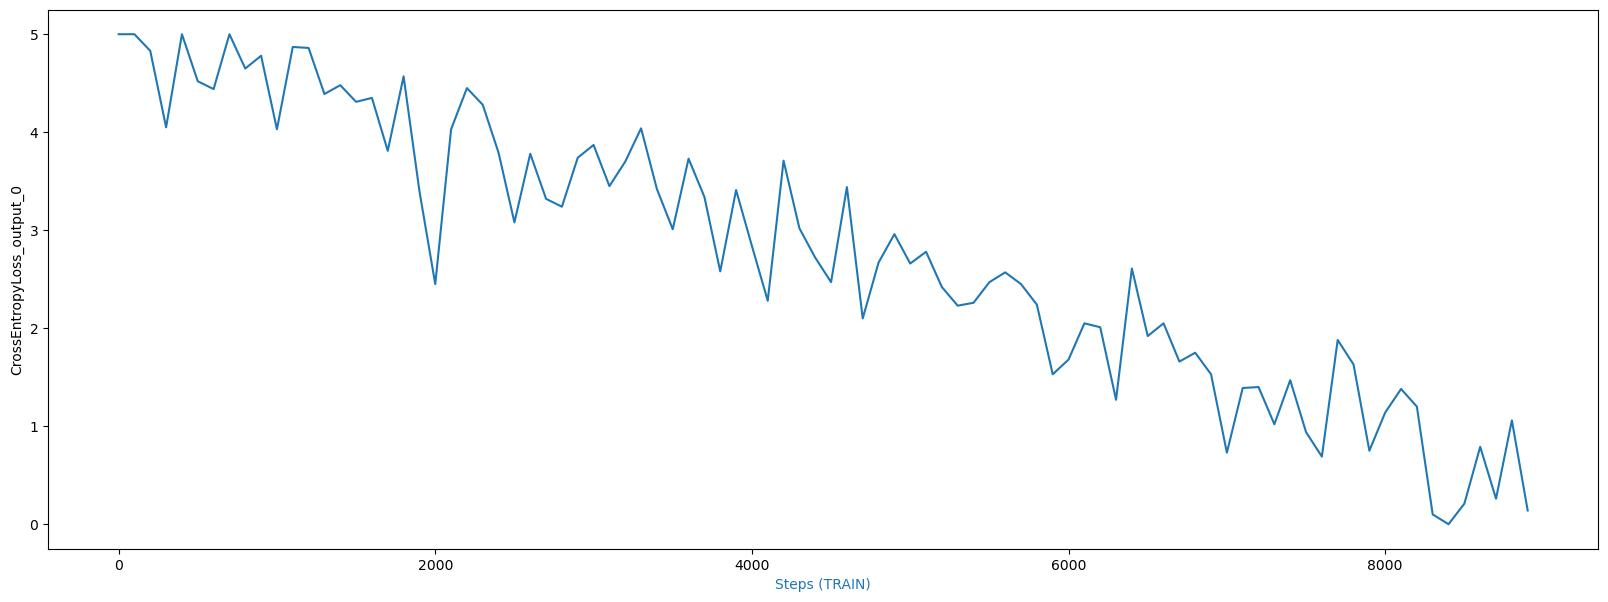

In [142]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [91]:
print(estimator.latest_job_debugger_artifacts_path())

s3://sagemaker-us-east-1-834258455530/MAIN-2024-08-28-17-01-23-239/debug-output


**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [43]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [47]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-834258455530/MAIN-2024-08-28-17-01-23-239/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-834258455530/MAIN-2024-08-28-17-01-23-239/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-834258455530/MAIN-2024-08-28-17-01-23-239/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-834258455530/MAIN-2024-08-28-17-01-23-239/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-834258455530/MAIN-2024-08-28-17-01-23-239/rule-output

In [48]:
# TODO: Display the profiler output
import IPython
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

pytorch_model = PyTorchModel(model_data=estimator.model_data, role=sagemaker.get_execution_role(), entry_point='inference.py',py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large') # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-834258455530/MAIN-2024-08-28-17-01-23-239/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-834258455530/pytorch-inference-2024-08-28-17-52-41-537/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-08-28-17-52-52-209
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-08-28-17-52-53-033
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-08-28-17-52-53-033


-------!

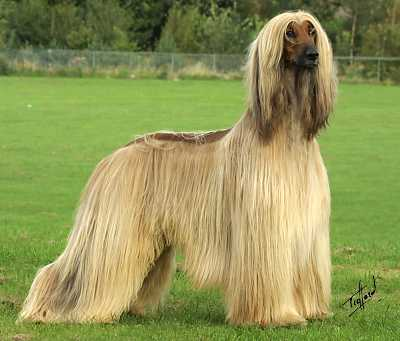

In [80]:
from PIL import Image
import io
Image.open('dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg')

In [78]:
# TODO: Run an prediction on the endpoint
with open("dogImages/test/002.Afghan_hound/Afghan_hound_00125.jpg", "rb") as image: # TODO: Your code to load and preprocess image to send to endpoint for prediction
  f = image.read()
  image_bytes = bytearray(f)

response = predictor.predict(image_bytes)

In [81]:
import numpy as np
np.argmax(response)

1

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()